In [1]:
import torch
import os
import matplotlib.pyplot as plt
import json
import torch.nn as nn
from IPython.display import HTML, display
from google.colab import drive
from datetime import datetime
from torch.utils.data import Dataset, DataLoader

drive.mount('/content/drive/')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


Mounted at /content/drive/


In [2]:
print(device)

cpu


In [3]:
def progress(batch, loss, batches):
    return HTML("""
        <label for="file">Training loss: {loss}</label>
        <progress
            value='{batch}'
            max='{batches}',
            style='width: 100%'
        >
            {batch}
        </progress>
    """.format(loss=loss, batch=batch, batches=batches))


In [4]:
class MusicDataset(Dataset):
  def __init__(self, data, seq_length = 64):
    self.data = data
    self.seq_length = seq_length

  def __getitem__(self, index):
    x = self.data[:, (index * self.seq_length):(index+1) * self.seq_length, :]
    return x

  def __len__(self):
    return int(self.data.size(1) / self.seq_length)

In [5]:
class DiscConvNet(nn.Module):
  def __init__(self):
    super(DiscConvNet, self).__init__()

    self.conv1 = nn.Conv2d(in_channels = 7, out_channels = 16, kernel_size = (2, 72), stride = (2,2))
    self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = (2, 1), stride = (2,2))
    self.conv3 = nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = (2, 1), stride = (2,2))
    self.conv4 = nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = (2, 1), stride = (2,2))
    self.conv5 = nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = (2, 1), stride = (2,2))
    self.out = nn.Linear(16 * 2, 1)
    self.prelu = nn.PReLU()
    self.sigmoid = nn.Sigmoid()
    self.batch_norm_2d = nn.BatchNorm2d(16)
    self.batch_norm_1d = nn.BatchNorm1d(128)
    self.dropout = nn.Dropout(0.5)


  def forward(self, input):
    x = self.prelu(self.batch_norm_2d(self.conv1(input)))
    x = self.dropout(x)
    x = self.prelu(self.batch_norm_2d(self.conv2(x)))
    x = self.dropout(x)
    x = self.prelu(self.batch_norm_2d(self.conv3(x)))
    x = self.dropout(x)
    x = self.prelu(self.batch_norm_2d(self.conv4(x)))
    x = self.dropout(x)
    x = self.prelu(self.batch_norm_2d(self.conv5(x)))
    x = x.flatten(1, -1)

    x = self.out(x)
    return x


class GenConvNet(nn.Module):
  def __init__(self, z_dim = 184):
    super(GenConvNet, self).__init__()
    self.z_dim = z_dim
    self.transpose_conv1 = nn.ConvTranspose2d(in_channels = z_dim, out_channels = 64, kernel_size = (2, 1), stride = (2,2))
    self.transpose_conv2 = nn.ConvTranspose2d(in_channels = 64, out_channels = 64, kernel_size = (2, 1), stride = (2,2))
    self.transpose_conv3 = nn.ConvTranspose2d(in_channels = 64, out_channels = 64, kernel_size = (2, 1), stride = (2,2))
    self.transpose_conv4 = nn.ConvTranspose2d(in_channels = 64, out_channels = 64, kernel_size = (2, 1), stride = (2,2))
    self.transpose_conv5 = nn.ConvTranspose2d(in_channels = 64, out_channels = 64, kernel_size = (2, 1), stride = (2,2))
    self.transpose_conv6 = nn.ConvTranspose2d(in_channels = 64, out_channels = 7, kernel_size = (2, 72), stride = (2,2))
    self.prelu = nn.PReLU()
    self.sigmoid = nn.Sigmoid()
    self.batch_norm_2d = nn.BatchNorm2d(64)
    self.batch_norm_1d = nn.BatchNorm1d(128)

  def forward(self, input):
    x = input.view(-1, self.z_dim, 1, 1)
    x = self.prelu(self.batch_norm_2d(self.transpose_conv1(x)))
    x = self.prelu(self.batch_norm_2d(self.transpose_conv2(x)))
    x = self.prelu(self.batch_norm_2d(self.transpose_conv3(x)))
    x = self.prelu(self.batch_norm_2d(self.transpose_conv4(x)))
    x = self.prelu(self.batch_norm_2d(self.transpose_conv5(x)))
    x = self.sigmoid(self.transpose_conv6(x))
    return x

In [6]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 and classname.find('ConvNet') == -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [7]:
def train_full_GAN(gen, disc, loader, z_dim, epochs=5, start_epoch = 0, checkpoint_path=''):
    gen.to(device).train()
    disc.to(device).train()

    disc_opt = torch.optim.RMSprop(disc.parameters(), lr= 0.00005)
    gen_opt = torch.optim.RMSprop(gen.parameters(), lr = 0.00005)

    fixed_noise = torch.randn(7, z_dim).to(device)

    max_steps = epochs*len(loader)
    progress_bar = display(progress(0, 0, max_steps), display_id=True)
    gen_losses = []
    disc_losses = []
    steps = 0
    for epoch in range(epochs):
        for i, real in enumerate(loader):
          real = real.to(device)
          batch_size = len(real)

          noise = torch.randn(batch_size, z_dim).to(device)

          disc_opt.zero_grad()

          fake = gen(noise).detach()

          disc_loss = -torch.mean(disc(real)) + torch.mean(disc(fake))
          disc_loss.backward()
          disc_opt.step()

          for p in disc.parameters():
            p.data.clamp_(-0.01, 0.01)

          if i % 5 == 0:

            #  Train Generator

            gen_opt.zero_grad()

            gen_imgs = gen(noise)

            gen_loss = -torch.mean(disc(gen_imgs))

            gen_loss.backward()
            gen_opt.step()

          gen_losses.append(gen_loss.item())
          disc_losses.append(disc_loss.item())
          progress_bar.update(progress(steps, (gen_losses[-1], disc_losses[-1]), max_steps))
          
          steps += 1

        ### Visualize the fake images
        if (epoch + 1) % 1000 == 0:
          fake = gen(fixed_noise)
          fake = fake.permute(0, 2, 1, 3).flatten(2, 3).flatten(0, 1).transpose(0,1)

          fake = fake.detach().cpu().numpy()

          fig = plt.figure(figsize = (10, 10))
          ax = fig.add_subplot(111)
          fake[fake < 0.7] = 0.0
          ax.imshow(fake, cmap='gray_r', vmin=0, vmax=1, interpolation = 'nearest')
          plt.title('Epoch {} Fake <0.7 set to 0'.format(epoch + start_epoch))
          plt.show()

          print('Epoch {} at {}'.format(epoch + start_epoch, datetime.now()))
        
          plt.plot(gen_losses, label='Generator loss')
          plt.plot(disc_losses, label='Discriminator loss')

        # Save checkpoints
        if (epoch + 1) % 1000 == 0:
          save_path = os.path.join(checkpoint_path, 'wasserloss_gan_all_tracks_checkpoint_gen_{}'.format(epoch + start_epoch))
          torch.save(gen.state_dict(), save_path)
          save_path = os.path.join(checkpoint_path, 'wasserloss_gan_all_tracks_checkpoint_disc_{}'.format(epoch + start_epoch))
          torch.save(disc.state_dict(), save_path)

          with open(os.path.join(checkpoint_path, 'wasserloss_gan_all_tracks_gen_loss'), 'a+') as outfile:
            json.dump(gen_losses, outfile)
          with open(os.path.join(checkpoint_path, 'wasserloss_gan_all_tracks_disc_loss'), 'a+') as outfile:
            json.dump(disc_losses, outfile)
        
    plt.plot(gen_losses, label='Generator loss')
    plt.plot(disc_losses, label='Discriminator loss')
    plt.xlabel('Batches')
    plt.ylabel('Training loss')
    plt.legend()
    plt.show()

In [8]:

input_path = 'data'
preparation_path = os.path.join(input_path, '02_preparation')
model_path = os.path.join(input_path, '03_model')
checkpoint_path = os.path.join(model_path, 'gan', 'checkpoints')



In [9]:
torch_tensor = torch.load(os.path.join(preparation_path, 'tensor.pt'))
torch_tensor = torch_tensor.type(torch.float32)

dataset = MusicDataset(torch_tensor, seq_length = 64)

loader = DataLoader(dataset, batch_size = 16, 
                                     drop_last=True)

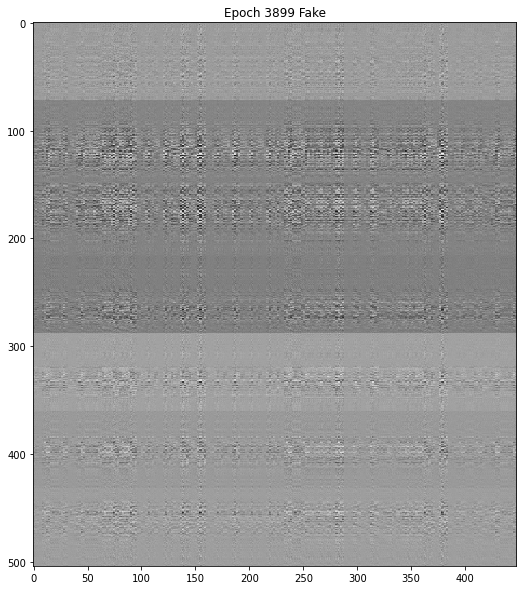

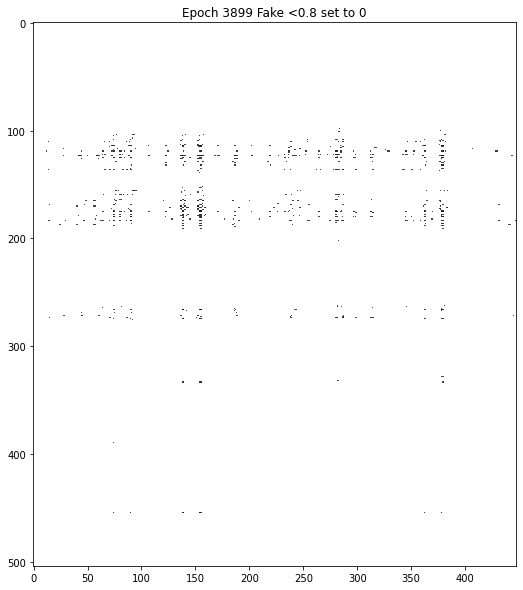

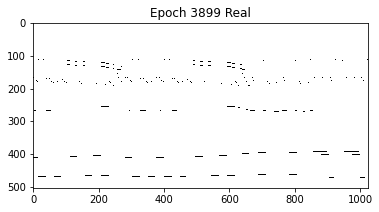

Epoch 3899 at 2022-09-24 18:53:08.544184


In [ ]:
z_dim = 100
disc = DiscConvNet()
gen = GenConvNet(z_dim=z_dim)
disc.apply(weights_init)
gen.apply(weights_init)
gen.load_state_dict(torch.load(os.path.join(checkpoint_path, 'wasserloss_gan_all_tracks_checkpoint_gen_3899'), map_location=torch.device(device)))
disc.load_state_dict(torch.load(os.path.join(checkpoint_path, 'wasserloss_gan_all_tracks_checkpoint_disc_3899'), map_location=torch.device(device)))


train_full_GAN(gen, disc, loader, z_dim, epochs = 4500, start_epoch = 3800, checkpoint_path=checkpoint_path)
